In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

In [2]:
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
from tensorflow.keras.callbacks import *

In [3]:
CLASS_NAMES= ['healthy', 'mild', 'moderate', 'severe']
IMG_HEIGHT = 128
IMG_WIDTH = 128
CHANNELS = 3
NUM_CLASSES = len(CLASS_NAMES)

# **ResNET**

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
#load data
data_x = np.load('data_x_aumentated_normalized.npy') #images
data_y = np.load('data_y_aumentated_normalized.npy') #labels
TOTAL_IMAGES = len(data_y)
print("TOTAL_IMAGES = ", TOTAL_IMAGES)

TOTAL_IMAGES =  2368


# **Splitting data in train - validation - test**

In [6]:
#percentage of the dataset which will be on TRAIN - TEST - VALIDATION
TRAIN_PERCENTAGE = 0.8
TEST_PERCENTAGE = 0.1
VALIDATION_PERCENTAGE = 0.1

In [7]:
train_size = int(TRAIN_PERCENTAGE * TOTAL_IMAGES)
test_size = int(TEST_PERCENTAGE * TOTAL_IMAGES)
validation_size = int(VALIDATION_PERCENTAGE * TOTAL_IMAGES)

In [8]:
train_x = data_x[:train_size]
train_y = data_y[:train_size]
data_x = data_x[train_size:]
data_y = data_y[train_size:]

test_x = data_x[:test_size]
test_y = data_y[:test_size]
data_x = data_x[test_size:]
data_y = data_y[test_size:]

validation_x = data_x #all the remainder we can let on validation
validation_y = data_y
del data_x
del data_y

In [9]:
print("train_size = ", len(train_y))
print("test_size = ", len(test_y))
print("validation_size = ", len(validation_y))

train_size =  1894
test_size =  236
validation_size =  238


In [10]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from IPython.display import SVG
import scipy.misc

In [12]:
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.applications import EfficientNetB1
# from tensorflow.keras.applications import EfficientNetB2
# from tensorflow.keras.applications import EfficientNetB3
# from tensorflow.keras.applications import EfficientNetB4
# from tensorflow.keras.applications import EfficientNetB5
# from tensorflow.keras.applications import EfficientNetB6
# from tensorflow.keras.applications import EfficientNetB7
# from tensorflow.keras.applications import *

In [13]:
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

C:\Users\tmcle\.conda\envs\tf\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [14]:
model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(IMG_HEIGHT,IMG_WIDTH, CHANNELS),
    pooling=None,
    classes=NUM_CLASSES,
   # classifier_activation="softmax",
#    **kwargs
)

219055592/219055592 [==============================] - 11s 0us/step


In [16]:
from tensorflow.keras import models
from tensorflow.keras import layers

new_model = models.Sequential()
new_model.add(model)
#3rd conv layer
new_model.add(tf.keras.layers.Conv2D(32, 3, padding="same"))
new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.Activation("relu"))
new_model.add(tf.keras.layers.MaxPooling2D(2))
#4th conv layer
new_model.add(tf.keras.layers.Conv2D(64, 3, padding="same"))
new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.Activation("relu"))
new_model.add(tf.keras.layers.MaxPooling2D(2))
#Flatten Layer
new_model.add(tf.keras.layers.Flatten())

new_model.add(tf.keras.layers.Dense(128, kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.Activation("relu"))
new_model.add(tf.keras.layers.Dropout(0.2))
#new_model.add(tf.keras.layers.l2( l=0.01))
#new_model.add(layers.GlobalAveragePooling2D())
#output Dense Layer
new_model.add(tf.keras.layers.Dense(NUM_CLASSES))
new_model.add(tf.keras.layers.Activation('softmax'))
adam = tf.keras.optimizers.Adam(lr=0.001)


C:\Users\tmcle\.conda\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 conv2d_205 (Conv2D)         (None, 2, 2, 32)          442400    
                                                                 
 batch_normalization_205 (Ba  (None, 2, 2, 32)         128       
 tchNormalization)                                               
                                                                 
 activation_205 (Activation)  (None, 2, 2, 32)         0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                      

In [18]:
epochs = 100

#compila e treina o modelo com os dados carregados
new_model.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=adam)
model_trained = new_model.fit(train_x, train_y,epochs=epochs,verbose=2,validation_data=(validation_x, validation_y),shuffle=False)

Epoch 1/100
60/60 - 60s - loss: 1.7954 - acc: 0.5940 - val_loss: 2.1364 - val_acc: 0.3025 - 60s/epoch - 1s/step
Epoch 2/100
60/60 - 33s - loss: 1.1605 - acc: 0.8126 - val_loss: 2.2514 - val_acc: 0.3950 - 33s/epoch - 543ms/step
Epoch 3/100
60/60 - 32s - loss: 0.8234 - acc: 0.8976 - val_loss: 2.5284 - val_acc: 0.2689 - 32s/epoch - 540ms/step
Epoch 4/100
60/60 - 32s - loss: 0.6758 - acc: 0.9234 - val_loss: 1.6505 - val_acc: 0.5672 - 32s/epoch - 538ms/step
Epoch 5/100
60/60 - 32s - loss: 0.5004 - acc: 0.9551 - val_loss: 1.2186 - val_acc: 0.6849 - 32s/epoch - 537ms/step
Epoch 6/100
60/60 - 32s - loss: 0.4392 - acc: 0.9541 - val_loss: 1.1844 - val_acc: 0.7437 - 32s/epoch - 537ms/step
Epoch 7/100
60/60 - 32s - loss: 0.3401 - acc: 0.9673 - val_loss: 2.7487 - val_acc: 0.4832 - 32s/epoch - 537ms/step
Epoch 8/100
60/60 - 32s - loss: 0.2904 - acc: 0.9667 - val_loss: 1.1514 - val_acc: 0.7437 - 32s/epoch - 537ms/step
Epoch 9/100
60/60 - 32s - loss: 0.2365 - acc: 0.9731 - val_loss: 0.8907 - val_acc: 

Epoch 71/100
60/60 - 32s - loss: 5.2562e-04 - acc: 1.0000 - val_loss: 0.1265 - val_acc: 0.9538 - 32s/epoch - 536ms/step
Epoch 72/100
60/60 - 32s - loss: 5.1106e-04 - acc: 1.0000 - val_loss: 0.1263 - val_acc: 0.9580 - 32s/epoch - 536ms/step
Epoch 73/100
60/60 - 32s - loss: 4.9554e-04 - acc: 1.0000 - val_loss: 0.1276 - val_acc: 0.9580 - 32s/epoch - 536ms/step
Epoch 74/100
60/60 - 32s - loss: 4.9262e-04 - acc: 1.0000 - val_loss: 0.1296 - val_acc: 0.9580 - 32s/epoch - 536ms/step
Epoch 75/100
60/60 - 32s - loss: 4.7137e-04 - acc: 1.0000 - val_loss: 0.1297 - val_acc: 0.9580 - 32s/epoch - 536ms/step
Epoch 76/100
60/60 - 32s - loss: 4.8303e-04 - acc: 1.0000 - val_loss: 0.1320 - val_acc: 0.9622 - 32s/epoch - 536ms/step
Epoch 77/100
60/60 - 32s - loss: 4.9610e-04 - acc: 1.0000 - val_loss: 0.1322 - val_acc: 0.9622 - 32s/epoch - 536ms/step
Epoch 78/100
60/60 - 32s - loss: 4.9122e-04 - acc: 1.0000 - val_loss: 0.1331 - val_acc: 0.9622 - 32s/epoch - 536ms/step
Epoch 79/100
60/60 - 32s - loss: 4.5873e

In [19]:
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                

 batch_normalization_10 (BatchN  (None, 13, 13, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 13, 13, 64)  192         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 13, 13, 96)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 13, 13, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 batch_normalization_19 (BatchN  (None, 13, 13, 32)  96          ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_22 (BatchN  (None, 13, 13, 48)  144         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 13, 13, 32)   0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 activation_22 (Activation)     (None, 13, 13, 48)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_18

                                                                                                  
 block35_3_mixed (Concatenate)  (None, 13, 13, 128)  0           ['activation_24[0][0]',          
                                                                  'activation_26[0][0]',          
                                                                  'activation_29[0][0]']          
                                                                                                  
 block35_3_conv (Conv2D)        (None, 13, 13, 320)  41280       ['block35_3_mixed[0][0]']        
                                                                                                  
 block35_3 (Lambda)             (None, 13, 13, 320)  0           ['block35_2_ac[0][0]',           
                                                                  'block35_3_conv[0][0]']         
                                                                                                  
 block35_3

                                                                                                  
 activation_40 (Activation)     (None, 13, 13, 48)   0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 13, 13, 32)   10240       ['block35_4_ac[0][0]']           
                                                                                                  
 conv2d_38 (Conv2D)             (None, 13, 13, 32)   9216        ['activation_37[0][0]']          
                                                                                                  
 conv2d_41 (Conv2D)             (None, 13, 13, 64)   27648       ['activation_40[0][0]']          
                                                                                                  
 batch_normalization_36 (BatchN  (None, 13, 13, 32)  96          ['conv2d_36[0][0]']              
 ormalizat

 block35_6 (Lambda)             (None, 13, 13, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 13, 13, 320)  0           ['block35_6[0][0]']              
                                                                                                  
 conv2d_51 (Conv2D)             (None, 13, 13, 32)   10240       ['block35_6_ac[0][0]']           
                                                                                                  
 batch_normalization_51 (BatchN  (None, 13, 13, 32)  96          ['conv2d_51[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 conv2d_59 (Conv2D)             (None, 13, 13, 64)   27648       ['activation_58[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (None, 13, 13, 32)  96          ['conv2d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_56 (BatchN  (None, 13, 13, 32)  96          ['conv2d_56[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_59 (BatchN  (None, 13, 13, 64)  192         ['conv2d_59[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_69 (BatchN  (None, 13, 13, 32)  96          ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_69 (Activation)     (None, 13, 13, 32)   0           ['batch_normalization_69[0][0]'] 
                                                                                                  
 conv2d_67 (Conv2D)             (None, 13, 13, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 conv2d_70 (Conv2D)             (None, 13, 13, 48)   13824       ['activation_69[0][0]']          
                                                                                                  
 batch_normalization_67 (BatchN  (None, 13, 13, 32)  96          ['conv2d_67[0][0]']              
 ormalizat

                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_77 (Conv2D)             (None, 6, 6, 128)    139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_normalization_77 (BatchN  (None, 6, 6, 128)   384         ['conv2d_77[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_77 (Activation)     (None, 6, 6, 128)    0           ['batch_normalization_77[0][0]'] 
                                                                                                  
 conv2d_78 (Conv2D)             (None, 6, 6, 160)    143360      ['activation_77[0][0]']          
          

 activation_85 (Activation)     (None, 6, 6, 128)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 conv2d_86 (Conv2D)             (None, 6, 6, 160)    143360      ['activation_85[0][0]']          
                                                                                                  
 batch_normalization_86 (BatchN  (None, 6, 6, 160)   480         ['conv2d_86[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_86 (Activation)     (None, 6, 6, 160)    0           ['batch_normalization_86[0][0]'] 
                                                                                                  
 conv2d_84 (Conv2D)             (None, 6, 6, 192)    208896      ['block17_2_ac[0][0]']           
          

 activation_94 (Activation)     (None, 6, 6, 160)    0           ['batch_normalization_94[0][0]'] 
                                                                                                  
 conv2d_92 (Conv2D)             (None, 6, 6, 192)    208896      ['block17_4_ac[0][0]']           
                                                                                                  
 conv2d_95 (Conv2D)             (None, 6, 6, 192)    215040      ['activation_94[0][0]']          
                                                                                                  
 batch_normalization_92 (BatchN  (None, 6, 6, 192)   576         ['conv2d_92[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_95 (BatchN  (None, 6, 6, 192)   576         ['conv2d_95[0][0]']              
 ormalizat

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_103 (Batch  (None, 6, 6, 192)   576         ['conv2d_103[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_100 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_100[0][0]']
                                                                                                  
 activation_103 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_103[0][0]']
                                                                                                  
 block17_7_mixed (Concatenate)  (None, 6, 6, 384)    0           ['activation_100[0][0]',         
          

 activation_111 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_111[0][0]']
                                                                                                  
 block17_9_mixed (Concatenate)  (None, 6, 6, 384)    0           ['activation_108[0][0]',         
                                                                  'activation_111[0][0]']         
                                                                                                  
 block17_9_conv (Conv2D)        (None, 6, 6, 1088)   418880      ['block17_9_mixed[0][0]']        
                                                                                                  
 block17_9 (Lambda)             (None, 6, 6, 1088)   0           ['block17_8_ac[0][0]',           
                                                                  'block17_9_conv[0][0]']         
                                                                                                  
 block17_9

 block17_11 (Lambda)            (None, 6, 6, 1088)   0           ['block17_10_ac[0][0]',          
                                                                  'block17_11_conv[0][0]']        
                                                                                                  
 block17_11_ac (Activation)     (None, 6, 6, 1088)   0           ['block17_11[0][0]']             
                                                                                                  
 conv2d_121 (Conv2D)            (None, 6, 6, 128)    139264      ['block17_11_ac[0][0]']          
                                                                                                  
 batch_normalization_121 (Batch  (None, 6, 6, 128)   384         ['conv2d_121[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 batch_normalization_129 (Batch  (None, 6, 6, 128)   384         ['conv2d_129[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_129 (Activation)    (None, 6, 6, 128)    0           ['batch_normalization_129[0][0]']
                                                                                                  
 conv2d_130 (Conv2D)            (None, 6, 6, 160)    143360      ['activation_129[0][0]']         
                                                                                                  
 batch_normalization_130 (Batch  (None, 6, 6, 160)   480         ['conv2d_130[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 batch_normalization_138 (Batch  (None, 6, 6, 160)   480         ['conv2d_138[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_138 (Activation)    (None, 6, 6, 160)    0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_136 (Conv2D)            (None, 6, 6, 192)    208896      ['block17_15_ac[0][0]']          
                                                                                                  
 conv2d_139 (Conv2D)            (None, 6, 6, 192)    215040      ['activation_138[0][0]']         
                                                                                                  
 batch_normalization_136 (Batch  (None, 6, 6, 192)   576         ['conv2d_136[0][0]']             
 Normaliza

 conv2d_147 (Conv2D)            (None, 6, 6, 192)    215040      ['activation_146[0][0]']         
                                                                                                  
 batch_normalization_144 (Batch  (None, 6, 6, 192)   576         ['conv2d_144[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_147 (Batch  (None, 6, 6, 192)   576         ['conv2d_147[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_144 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_144[0][0]']
                                                                                                  
 activatio

                                                                                                  
 activation_152 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_152[0][0]']
                                                                                                  
 activation_155 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_155[0][0]']
                                                                                                  
 block17_20_mixed (Concatenate)  (None, 6, 6, 384)   0           ['activation_152[0][0]',         
                                                                  'activation_155[0][0]']         
                                                                                                  
 block17_20_conv (Conv2D)       (None, 6, 6, 1088)   418880      ['block17_20_mixed[0][0]']       
                                                                                                  
 block17_2

 activation_165 (Activation)    (None, 2, 2, 224)    0           ['batch_normalization_165[0][0]']
                                                                                                  
 conv2d_163 (Conv2D)            (None, 2, 2, 192)    399360      ['mixed_7a[0][0]']               
                                                                                                  
 conv2d_166 (Conv2D)            (None, 2, 2, 256)    172032      ['activation_165[0][0]']         
                                                                                                  
 batch_normalization_163 (Batch  (None, 2, 2, 192)   576         ['conv2d_163[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_166 (Batch  (None, 2, 2, 256)   768         ['conv2d_166[0][0]']             
 Normaliza

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_174 (Batch  (None, 2, 2, 256)   768         ['conv2d_174[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_171 (Activation)    (None, 2, 2, 192)    0           ['batch_normalization_171[0][0]']
                                                                                                  
 activation_174 (Activation)    (None, 2, 2, 256)    0           ['batch_normalization_174[0][0]']
                                                                                                  
 block8_3_mixed (Concatenate)   (None, 2, 2, 448)    0           ['activation_171[0][0]',         
          

 activation_182 (Activation)    (None, 2, 2, 256)    0           ['batch_normalization_182[0][0]']
                                                                                                  
 block8_5_mixed (Concatenate)   (None, 2, 2, 448)    0           ['activation_179[0][0]',         
                                                                  'activation_182[0][0]']         
                                                                                                  
 block8_5_conv (Conv2D)         (None, 2, 2, 2080)   933920      ['block8_5_mixed[0][0]']         
                                                                                                  
 block8_5 (Lambda)              (None, 2, 2, 2080)   0           ['block8_4_ac[0][0]',            
                                                                  'block8_5_conv[0][0]']          
                                                                                                  
 block8_5_

 block8_7 (Lambda)              (None, 2, 2, 2080)   0           ['block8_6_ac[0][0]',            
                                                                  'block8_7_conv[0][0]']          
                                                                                                  
 block8_7_ac (Activation)       (None, 2, 2, 2080)   0           ['block8_7[0][0]']               
                                                                                                  
 conv2d_192 (Conv2D)            (None, 2, 2, 192)    399360      ['block8_7_ac[0][0]']            
                                                                                                  
 batch_normalization_192 (Batch  (None, 2, 2, 192)   576         ['conv2d_192[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 batch_normalization_200 (Batch  (None, 2, 2, 192)   576         ['conv2d_200[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_200 (Activation)    (None, 2, 2, 192)    0           ['batch_normalization_200[0][0]']
                                                                                                  
 conv2d_201 (Conv2D)            (None, 2, 2, 224)    129024      ['activation_200[0][0]']         
                                                                                                  
 batch_normalization_201 (Batch  (None, 2, 2, 224)   672         ['conv2d_201[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

In [20]:
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

In [21]:
#print(getLayerIndexByName(new_model, 'flatten_1')) #just used to get the index of flatten layer

In [22]:
model_name = f'InceptionResNetV2-baseline-holdout-{epochs}epochs_normalized.npy'
new_model.save(model_name)

INFO:tensorflow:Assets written to: InceptionResNetV2-baseline-holdout-100epochs_normalized.npy\assets


INFO:tensorflow:Assets written to: InceptionResNetV2-baseline-holdout-100epochs_normalized.npy\assets


# **Random Forest - flatting**

In [23]:
new_model_rf = keras.Model(inputs=new_model.input, outputs=new_model.get_layer(index=9).output)
featureVector = new_model_rf.predict(train_x)

60/60 [==============================] - 11s 136ms/step


In [24]:
featureVector2 = new_model_rf.predict(test_x)

8/8 [==============================] - 2s 257ms/step


In [25]:
print(featureVector.shape)

(1894, 64)


In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
clf=RandomForestClassifier(n_estimators=100)

clf.fit(featureVector,train_y)



RandomForestClassifier()

In [28]:
test_x.shape

(236, 128, 128, 3)

In [29]:
y_pred=clf.predict(featureVector2)

In [30]:
featureVector.shape

(1894, 64)

In [31]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(test_y, y_pred))

Accuracy: 0.9576271186440678


In [32]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
clf = DecisionTreeClassifier(random_state=0)

# **Testes**

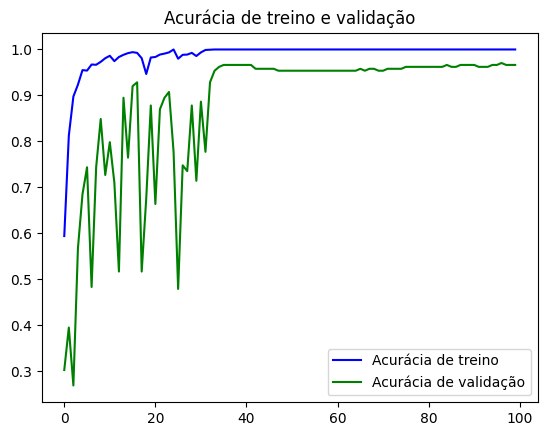

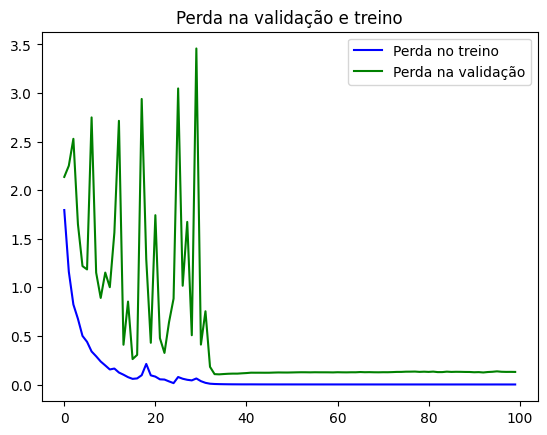

In [34]:
import matplotlib.pyplot as plt

accuracy = model_trained.history['acc']
val_accuracy = model_trained.history['val_acc']
loss = model_trained.history['loss']
val_loss = model_trained.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Acurácia de treino')
plt.plot(epochs, val_accuracy, 'g', label='Acurácia de validação')
plt.title('Acurácia de treino e validação')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Perda no treino')
plt.plot(epochs, val_loss, 'g', label='Perda na validação')
plt.title('Perda na validação e treino')
plt.legend()
plt.show()

In [35]:
#avalia a fase de teste

model_loss, model_accuracy = new_model.evaluate(test_x, test_y, verbose=1)

#mostra o resultado
print('Test loss:', model_loss)
print('Test accuracy:', model_accuracy)

8/8 [==============================] - 1s 138ms/step - loss: 0.1546 - acc: 0.9576
Test loss: 0.15464024245738983
Test accuracy: 0.9576271176338196


In [36]:
#faz a predição das imagens

from tensorflow.keras.utils import to_categorical

pred = new_model.predict(test_x, verbose=0)

pred_probs = np.argmax(pred,axis=1)

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [38]:
cm = confusion_matrix(test_y, pred_probs)

In [39]:
#gera os valores de falso positivo, falso negativo, verdadeiro positivo e verdadeiro negativo
fp = cm.sum(axis=0) - np.diag(cm)  
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)

f1score = f1_score(test_y, pred_probs, average='weighted')
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy    = (tp + tn) / (tp + tn + fp + fn)
precision   = tp / (tp + fp)


print("F1 Score:", f1score)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:  ", precision)
print("Accuracy:   ", accuracy)

F1 Score: 0.9572593876345757
Sensitivity: [0.97297297 1.         0.88679245 0.96551724]
Specificity: [0.98765432 0.98918919 0.98907104 0.97752809]
Precision:   [0.97297297 0.96226415 0.95918367 0.93333333]
Accuracy:    [0.98305085 0.99152542 0.96610169 0.97457627]
